In [15]:
import pandas as pd
import pathlib
import numpy as np
import scipy
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc

import preprocessing

def Tau(x):
    if np.all(~np.isnan(x)):
        if np.min(x) >= 0:
            if np.max(x) != 0:
                x = 1 - (x / np.max(x))
                res = np.sum(x) / (len(x) - 1)
            else:
                res = 0
        else:
            res = None
            raise ValueError("Expression values have to be positive!")
    else:
        res = None
        raise ValueError("No data for this gene available.")
    return res

def Tau_mat(X):
    if np.all(~np.isnan(X)):
        if np.min(X) >= 0:
            x = 1 - (X / np.max(X,axis=0))
            res = np.sum(X,axis=0) / (len(x) - 1)
        else:
            res = None
            raise ValueError("Expression values have to be positive!")
    else:
        res = None
        raise ValueError("No data for this gene available.")
    return res

# Within sample analysis

In [2]:
adata_tpm = preprocessing.load_rnaseq_sample_selected_tissues_anndata(
     X_path="../results/rnaseq_sample_selected_tissues_tpm.mm",
     genes_rows_path="../results/rnaseq_sample_selected_tissues_genes_rows.csv",
     samples_columns_path="../results/rnaseq_sample_selected_tissues_samples_columns.csv",
     samples_metadata_path="../results/rnaseq_sample_selected_tissues_metadata.csv",
)
# subset to yarn-filtered genes
genes_rows_path="../results/rnaseq_sample_selected_tissues_yarn_normalized_genes_rows.csv",
adata_tpm = adata_tpm[:,genes_rows_path['Name'].values]

In [ ]:
progeny = dc.get_progeny(top=500)
dc.run_gsva(mat=adata_tpm, net=progeny, use_raw=False)

# Across sample analysis

<Axes: >

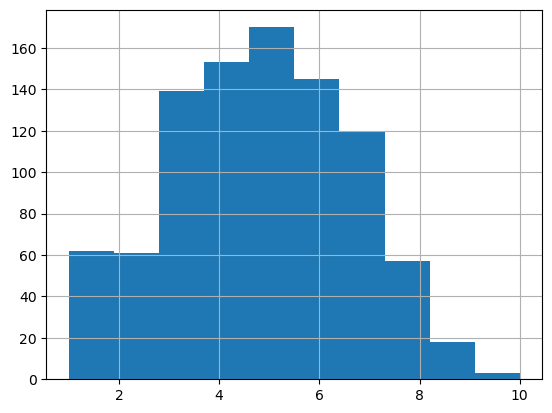

In [30]:
adata = preprocessing.load_rnaseq_sample_selected_tissues_anndata(
    X_path="../results/rnaseq_sample_selected_tissues_yarn_normalized.mm",
    genes_rows_path="../results/rnaseq_sample_selected_tissues_yarn_normalized_genes_rows.csv",
    samples_columns_path="../results/rnaseq_sample_selected_tissues_samples_columns.csv",
    samples_metadata_path="../results/rnaseq_sample_selected_tissues_metadata.csv",
)
adata.layers['qsmooth'] = adata.X
if 'log1p' not in adata.uns:
    sc.pp.log1p(adata)
sc.pp.pca(adata)

gene_names_df = pd.read_csv("../results/rnaseq_sample_selected_tissues_genes_rows.csv").set_index('Name')
adata.var = adata.var.join(gene_names_df)

adata.obs['donor_ids'].value_counts().hist()

## Simple specificity metrics on qsmooth normalized data

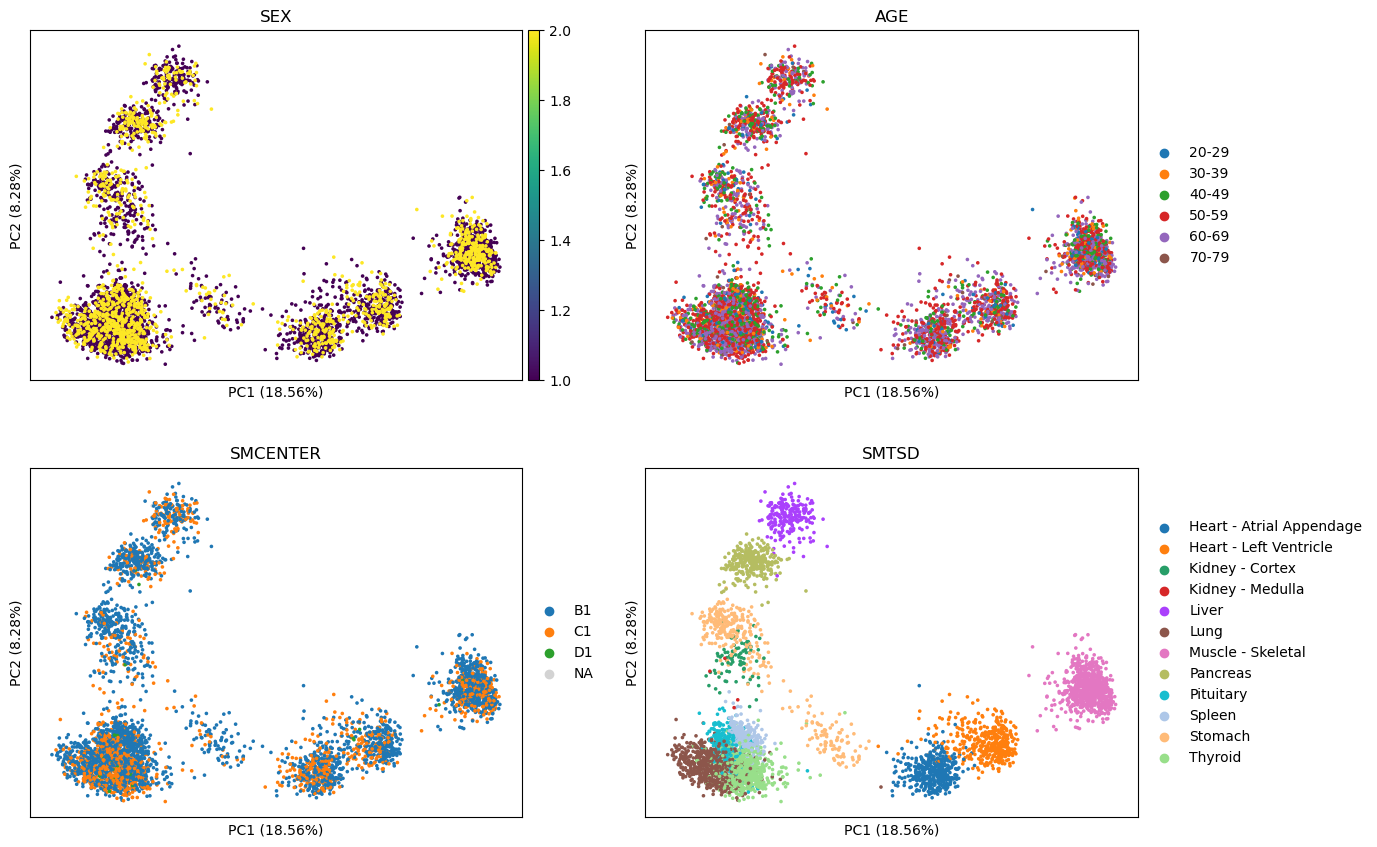

In [26]:
sc.pl.pca(adata,color=['SEX','AGE','SMCENTER','SMTSD'],ncols=2,annotate_var_explained=True)

In [32]:
Tau(adata.X[:,0].toarray())

0.6690197678077521

## Differential expression on qsmooth normalized data

In [ ]:
adata.['Kidney - Cortex', 'Kidney - Medulla]

In [5]:
liver = 'Liver_expressed'
rest = ['Muscle - Skeletal_expressed',
        'Heart - Atrial Appendage_expressed', 'Thyroid_expressed',
        'Lung_expressed', 'Spleen_expressed', 'Pancreas_expressed',
        'Stomach_expressed', 'Heart - Left Ventricle_expressed',
        'Pituitary_expressed',  'Kidney - Cortex_expressed',
        'Kidney - Medulla_expressed']

# for t in adata.obs['SMTSD'].unique():
#     tissue_idx = adata.obs['SMTSD']==t
#     adata.var[t+'_expressed'] = ((adata[tissue_idx].X>0).A.sum(0) > 0)

# liver_specific_on = (~adata.var[rest].sum(1)>0) & adata.var[[liver]].sum(1)>0

liverVSrest = (adata.obs['SMTSD'] == 'Liver')
adata.obs['liverVSrest'] = ''
adata.obs.loc[liverVSrest,'liverVSrest'] = 'Liver'
adata.obs.loc[~liverVSrest,'liverVSrest'] = 'rest'

In [6]:
sc.tl.rank_genes_groups(adata,groupby='SMTSD',method='wilcoxon',key_added='tissue_pairwise_wilcoxon')

results_df = sc.get.rank_genes_groups_df(adata,group='Liver',key='tissue_pairwise_wilcoxon').set_index('names').join(adata.var).set_index('Description')

# input to TF activity inference with collectri
mat = results_df[['scores']].T.rename(index={'scores': 'liver.vs.rest'})
mat = mat[[c for c in mat.columns if c!='LYNX1']] # LYNX1 is not in collectri network and can be safely ignored here

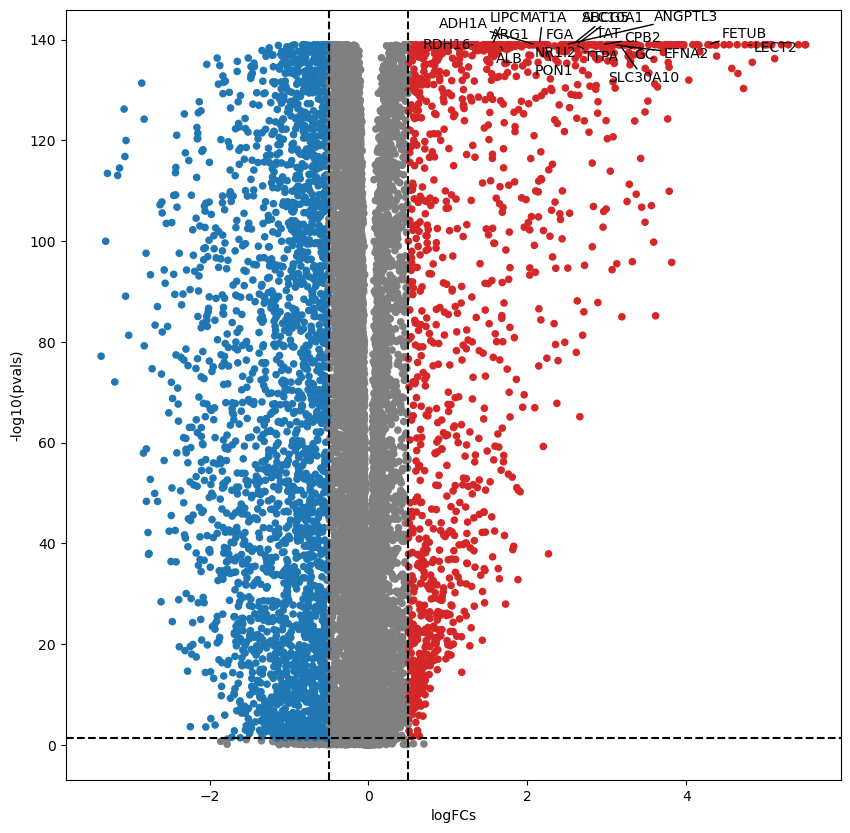

In [7]:
dc.plot_volcano_df(
    results_df,
    x='logfoldchanges',
    y='pvals_adj',
    top=20,
    figsize=(10, 10)
)

In [9]:
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [13]:
# # LYNX1 is a duplicated gene name
# display(mat.columns.value_counts().sort_values()[-3:])
# (collectri[['source','target']]=='LYNX1').any(axis=1).sum()

Description
MCUR1     1
ABCA3     1
ABCF1     1
AADAC     1
AAK1      1
         ..
ZW10      1
ZUFSP     1
ZSWIM8    1
ZSWIM7    1
ZSWIM6    1
Name: count, Length: 17955, dtype: int64

0

In [17]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 1 samples and 17957 targets for 764 sources.


,ABL1,AEBP1,AHR,AHRR,AIP,AIRE,AP1,APEX1,AR,ARID1A,...,ZNF384,ZNF395,ZNF410,ZNF423,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91,ZXDC
liver.vs.rest,0.145783,0.847786,4.693409,0.876832,0.04036,1.223897,2.250443,1.710674,1.348198,1.487207,...,1.199119,0.748578,-0.113777,-0.409802,-2.115259,0.23294,-0.535294,0.944847,-0.326809,-0.986151


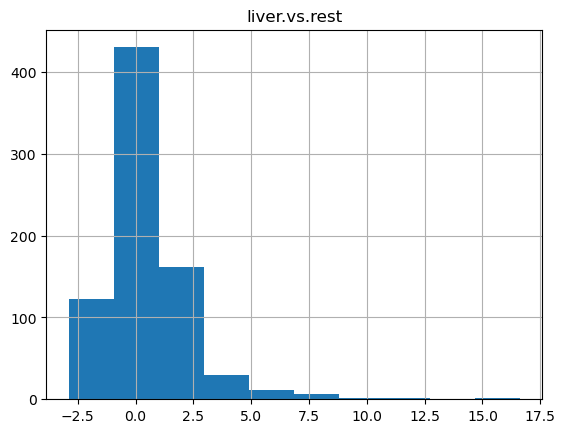

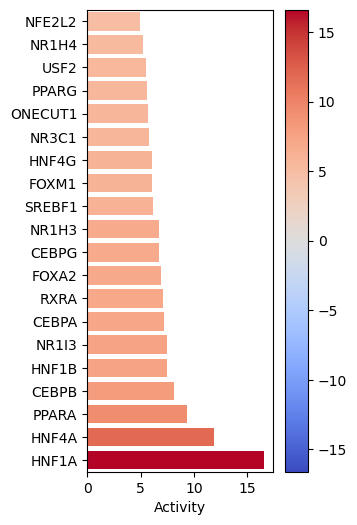

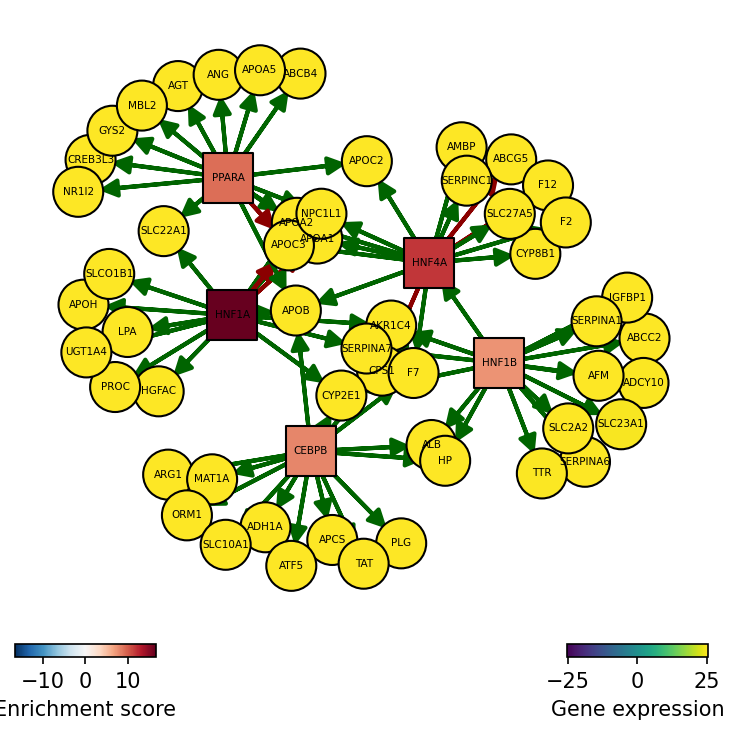

In [35]:
tf_acts.T.hist()
dc.plot_barplot(
    acts=tf_acts,
    contrast='liver.vs.rest',
    top=20,
    vertical=True,
    figsize=(3, 6)
)
dc.plot_network(
    net=collectri,
    obs=mat,
    act=tf_acts,
    n_sources=5,
    n_targets=15,
    node_size=50,
    figsize=(5, 5),
    c_pos_w='darkgreen',
    c_neg_w='darkred',
    vcenter=True
)

In [37]:
results_df

,scores,logfoldchanges,pvals,pvals_adj
Description,,,,
ABCG5,25.361298,2.566626,6.745162e-142,1.051129e-139
CA5A,25.361298,3.257214,6.745162e-142,1.051129e-139
HGFAC,25.361298,1.655313,6.745162e-142,1.051129e-139
APOA2,25.361298,3.009243,6.745162e-142,1.051129e-139
NPC1L1,25.361298,1.512164,6.745162e-142,1.051129e-139
...,...,...,...,...
CHMP3,-25.359158,-0.263785,7.121949e-142,1.051129e-139
ZNF431,-25.359264,-0.465145,7.102620e-142,1.051129e-139
IGF1R,-25.359745,-0.520962,7.016286e-142,1.051129e-139


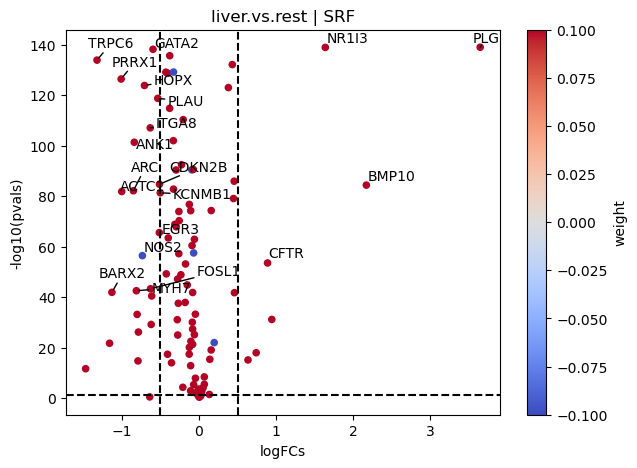

In [41]:
# Extract logFCs and pvals
logFCs = results_df.loc[[c for c in mat.columns if c!='LYNX1']][['logfoldchanges']].T.rename(index={'logfoldchanges': 'liver.vs.rest'})
pvals = results_df.loc[[c for c in mat.columns if c!='LYNX1']][['pvals_adj']].T.rename(index={'pvals_adj': 'liver.vs.rest'})

# Plot
dc.plot_volcano(
    logFCs,
    pvals,
    'liver.vs.rest',
    name='SRF',
    net=collectri,
    top=20,
    sign_thr=0.05,
    lFCs_thr=0.5
)

Running mlm on mat with 1 samples and 17957 targets for 14 sources.


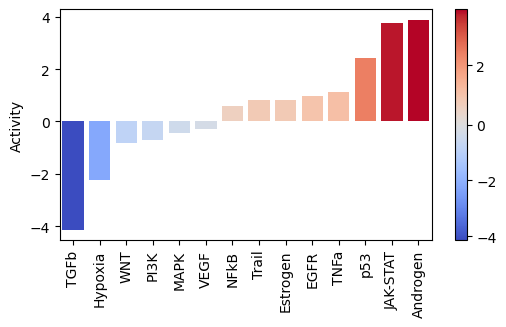

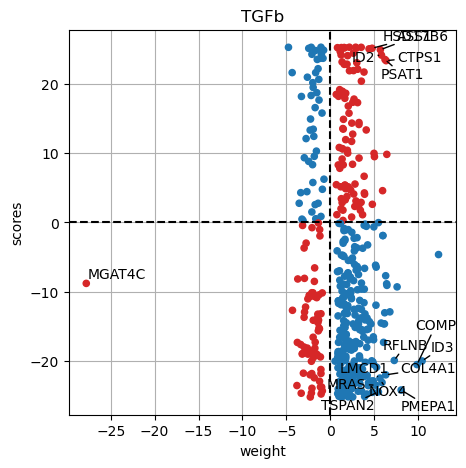

In [44]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny, verbose=True)
dc.plot_barplot(
    pathway_acts,
    'liver.vs.rest',
    top=25,
    vertical=False,
    figsize=(6, 3)
)
dc.plot_targets(results_df.loc[[c for c in mat.columns if c!='LYNX1']], stat='scores', source_name='TGFb', net=progeny, top=15)

In [52]:
dc.show_methods()

,Function,Name
0,run_aucell,AUCell.
1,run_consensus,Consensus score from top methods.
2,run_gsea,Gene Set Enrichment Analysis (GSEA).
3,run_gsva,Gene Set Variation Analysis (GSVA).
4,run_mdt,Multivariate Decision Tree (MDT).
5,run_mlm,Multivariate Linear Model (MLM).
6,run_ora,Over Representation Analysis (ORA).
7,run_udt,Univariate Decision Tree (UDT).
8,run_ulm,Univariate Linear Model (ULM).
9,run_viper,Virtual Inference of Protein-activity by Enric...


In [ ]:
dc.run_gsea(mat=mat, net=progeny)

In [ ]:
msigdb = dc.get_resource('MSigDB')
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]
# Infer enrichment with ora using significant deg
top_genes = results_df[results_df['pvals_adj'] < 0.05]

# Run ora
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)


dc.plot_dotplot(
    enr_pvals.sort_values('Combined score', ascending=False).head(15),
    x='Combined score',
    y='Term',
    s='Odds ratio',
    c='FDR p-value',
    scale=1.5,
    figsize=(3, 6)
)

# Plot
dc.plot_running_score(
    df=results_df,
    stat='stat',
    net=msigdb,
    source='geneset',
    target='genesymbol',
    set_name='TNFA_SIGNALING_VIA_NFKB'
)